In [13]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import PIL.Image
import random
random.seed(0)
from image_patch_functions import *
from dice_calculation import *
import os

# 1. Load training images and predictions (results)

In [6]:
result_path = "./results/sub14_data_mutation_20000minibatches/"

def sort_prediction_filenames(fnames):
    numbers = []
    for name in fnames:
        number = int(name.split('_')[-1].split('.')[0])
        numbers.append(number)
    correct_order = np.argsort(numbers)
    fnames_sorted = np.array(fnames)
    fnames_sorted = fnames_sorted[correct_order]
    return fnames_sorted

#####
# Training predictions file names
foldername = result_path + "training_results/"
train_prediction_names = glob.glob(foldername + '*.npy')

# Sort them by ascending number
train_prediction_names = sort_prediction_filenames(train_prediction_names)

print("Sorted training filenames: ")
print(train_prediction_names[:5])
print("...")

#####    
# Validation predictions file names
foldername = result_path + "validation_results/"
valid_prediction_names = glob.glob(foldername + '*.npy')

# Sort them by ascending number
valid_prediction_names = sort_prediction_filenames(valid_prediction_names)

print("\nSorted validation filenames: ")
print(valid_prediction_names)

#####
# Test predictions file names
foldername = result_path + "test_results/"
test_prediction_names = glob.glob(foldername + '*.npy')

# Sort them by ascending number
test_prediction_names = sort_prediction_filenames(test_prediction_names)

print("\nSorted test filenames: ")
print(test_prediction_names[:5])
print("...")

Sorted training filenames: 
['./results/sub14_data_mutation_20000minibatches/training_results\\train_probabilities_1.npy'
 './results/sub14_data_mutation_20000minibatches/training_results\\train_probabilities_2.npy'
 './results/sub14_data_mutation_20000minibatches/training_results\\train_probabilities_3.npy'
 './results/sub14_data_mutation_20000minibatches/training_results\\train_probabilities_4.npy'
 './results/sub14_data_mutation_20000minibatches/training_results\\train_probabilities_5.npy']
...

Sorted validation filenames: 
['./results/sub14_data_mutation_20000minibatches/validation_results\\val_probabilities_1.npy'
 './results/sub14_data_mutation_20000minibatches/validation_results\\val_probabilities_2.npy'
 './results/sub14_data_mutation_20000minibatches/validation_results\\val_probabilities_3.npy'
 './results/sub14_data_mutation_20000minibatches/validation_results\\val_probabilities_4.npy'
 './results/sub14_data_mutation_20000minibatches/validation_results\\val_probabilities_5.n

In [3]:
# Load the training images, masks and segmentations from the dataset
impaths_all = glob.glob(r'.\training\images\*.tif')
trainingsetsize = 15

#shuffle the images to take a random subset for training later
random.shuffle(impaths_all)

maskpaths_all = copy.deepcopy(impaths_all)
segpaths_all = copy.deepcopy(impaths_all)

#select the corresponding masks and segmentations
for i in range(len(impaths_all)):
    maskpaths_all[i] = impaths_all[i].replace('images','mask')
    maskpaths_all[i] = maskpaths_all[i].replace('.tif','_mask.gif')

    segpaths_all[i] = impaths_all[i].replace('images','1st_manual')
    segpaths_all[i] = segpaths_all[i].replace('training.tif','manual1.gif')
    
print("\n".join(impaths_all[:5]))

impaths = impaths_all # just to be compatible with the scripts
maskpaths = maskpaths_all
segpaths = segpaths_all


#load the training images
images, masks, segmentations = loadImages(impaths,maskpaths,segpaths)

print(images.shape)
print(masks.shape)
print(segmentations.shape)

.\training\images\31_training.tif
.\training\images\39_training.tif
.\training\images\37_training.tif
.\training\images\35_training.tif
.\training\images\21_training.tif
(20, 584, 565)
(20, 584, 565)
(20, 584, 565)


# 2. Find optimum threshold for each image

## Training set

In [8]:
train_opt_segmentations = []
train_opt_thresholds = []
train_opt_dice_scores = []
for i in range(trainingsetsize):
    prediction = np.load(train_prediction_names[i])
    train_opt_seg, train_opt_threshold, train_opt_dice = optimal_treshold(segmentations[i,:,:], masks[i,:,:], prediction)
    train_opt_segmentations.append(train_opt_seg)
    train_opt_thresholds.append(train_opt_threshold)
    train_opt_dice_scores.append(train_opt_dice)
    print("Training image {} \tMax. Dice score = {} \tOpt. threshold = {} ".format(i+1, train_opt_dice, train_opt_threshold) ) 

mean_dice_score_training = np.mean(train_opt_dice_scores)
mean_threshold_training = np.mean(train_opt_thresholds)
print("\nMean Dice score: {}".format(mean_dice_score_training))
print("Mean Threshold: {}".format(mean_threshold_training))

Training image 1 	Max. Dice score = 0.8023241126689402 	Opt. threshold = 0.8818181818181818 
Training image 2 	Max. Dice score = 0.8037722285929451 	Opt. threshold = 0.8590909090909091 
Training image 3 	Max. Dice score = 0.8272434551308974 	Opt. threshold = 0.8212121212121213 
Training image 4 	Max. Dice score = 0.8254335260115607 	Opt. threshold = 0.8515151515151516 
Training image 5 	Max. Dice score = 0.8235082530674234 	Opt. threshold = 0.8590909090909091 
Training image 6 	Max. Dice score = 0.8174719966759578 	Opt. threshold = 0.8590909090909091 
Training image 7 	Max. Dice score = 0.8130508225616921 	Opt. threshold = 0.8590909090909091 
Training image 8 	Max. Dice score = 0.78286170162842 	Opt. threshold = 0.896969696969697 
Training image 9 	Max. Dice score = 0.8366642968112279 	Opt. threshold = 0.7606060606060607 
Training image 10 	Max. Dice score = 0.7909610940637194 	Opt. threshold = 0.7984848484848486 
Training image 11 	Max. Dice score = 0.8153754015353624 	Opt. threshold 

## Validation set

In [11]:
valid_opt_segmentations = []
valid_opt_thresholds = []
valid_opt_dice_scores = []
for i in range(5):
    prediction = np.load(valid_prediction_names[i])
    valid_opt_seg, valid_opt_threshold, valid_opt_dice = optimal_treshold(segmentations[trainingsetsize+i,:,:], masks[trainingsetsize+i,:,:], prediction)
    valid_opt_segmentations.append(valid_opt_seg)
    valid_opt_thresholds.append(valid_opt_threshold)
    valid_opt_dice_scores.append(valid_opt_dice)
    print("Validation image {} \tMax. Dice score = {} \tOpt. threshold = {} ".format(i+1, valid_opt_dice, valid_opt_threshold) ) 
    
mean_dice_score_valid = np.mean(valid_opt_dice_scores)
mean_threshold_valid = np.mean(valid_opt_thresholds)
print("\nMean Dice score: {}".format(mean_dice_score_valid))
print("Mean Threshold: {}".format(mean_threshold_valid))

Validation image 1 	Max. Dice score = 0.826128456611656 	Opt. threshold = 0.7530303030303032 
Validation image 2 	Max. Dice score = 0.7908210207284733 	Opt. threshold = 0.8060606060606061 
Validation image 3 	Max. Dice score = 0.7918498336871312 	Opt. threshold = 0.7757575757575759 
Validation image 4 	Max. Dice score = 0.6979792793064911 	Opt. threshold = 0.7681818181818183 
Validation image 5 	Max. Dice score = 0.8043058648849295 	Opt. threshold = 0.843939393939394 

Mean Dice score: 0.7822168910437363
Mean Threshold: 0.7893939393939394


# 3. Apply the optimal limit (threshold) to the test set

In [12]:
# Assume that optimal is (puts more weight to the validation set):
opt_threshold = (mean_dice_score_training + mean_dice_score_valid) / 2.
print("Optimal threshold = ", opt_threshold)

Optimal threshold =  0.7972589678739552


In [17]:
# Create directory to store predictions for submission
dirName = "submission"
exists = os.path.isdir("./submission/")
if not(exists):
    os.mkdir(dirName)
    print("Directory ", dirName, " was created")
else:
    print("Directory ", dirName, " already exists")

Directory  submission  already exists


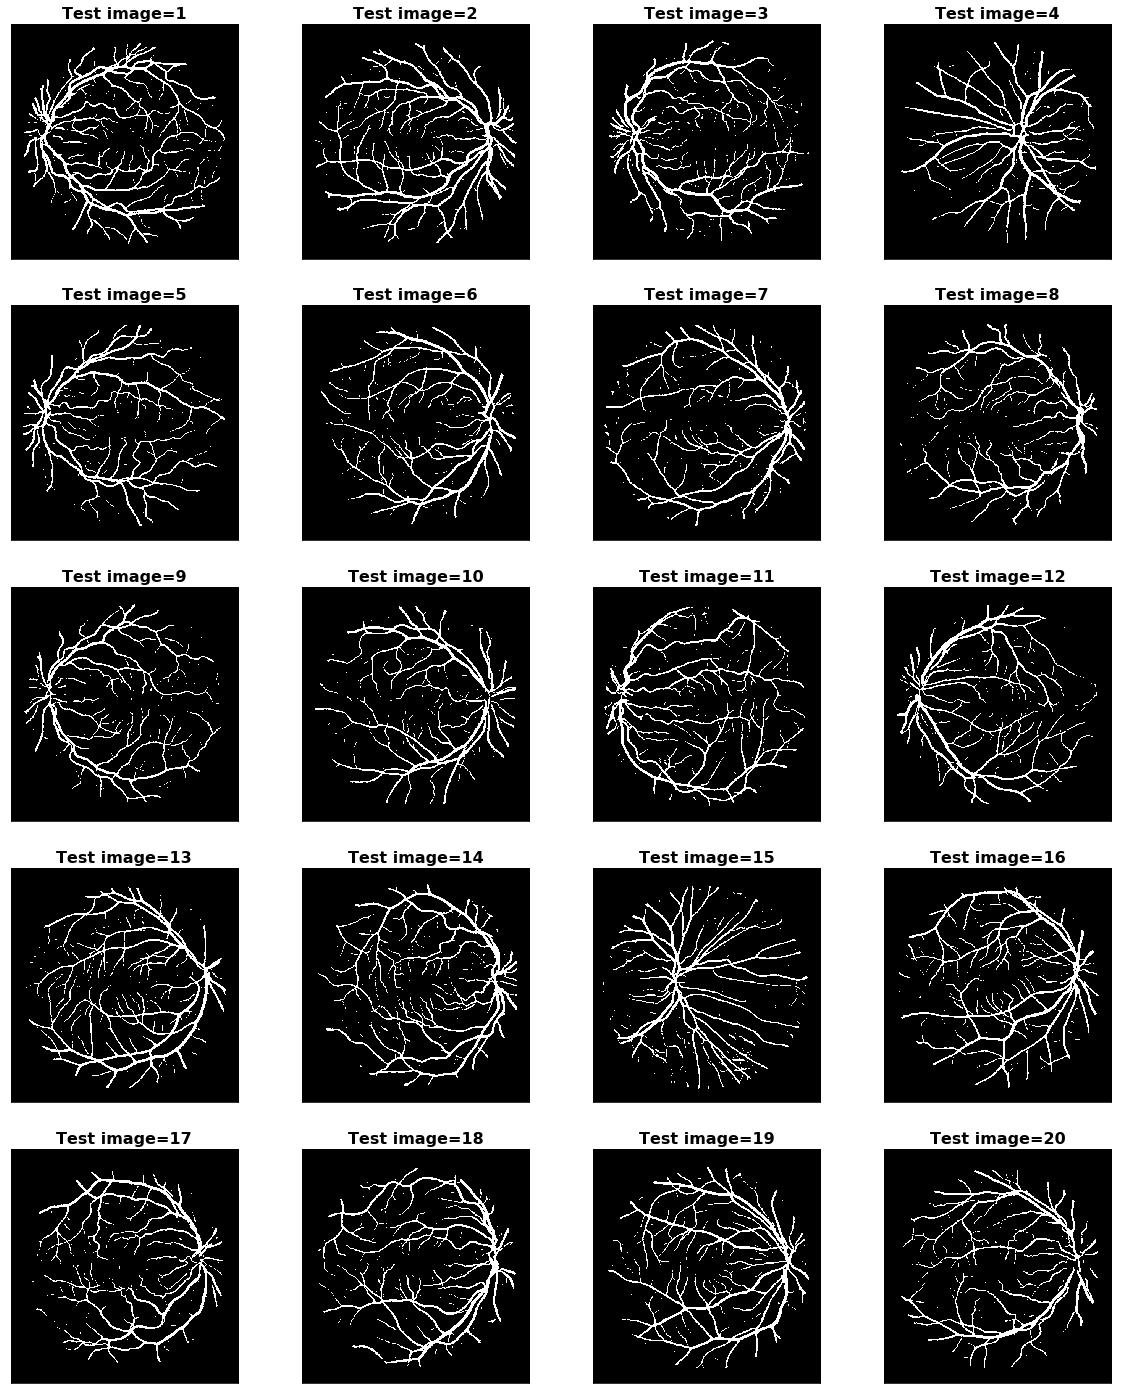

In [18]:
plt.rcParams["figure.figsize"] = (20,25)

nrows = 5
ncols = 4

# Thresholded test images
for i in range(len(test_prediction_names)):
    plt.subplot(nrows, ncols, i+1)
    # Load prediction for test image i
    thres_image = np.load(test_prediction_names[i])
    # Normalize
    thres_image /= np.amax(thres_image)
    # Apply the optimal threshold
    thres_image[thres_image>opt_threshold] = 1
    thres_image[thres_image<=opt_threshold] = 0
    # Show image
    plt.imshow(thres_image, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Test image={i+1}", fontsize=16, fontweight="bold")
    
    # Save each image as PNG file
    img = PIL.Image.fromarray(np.uint8(thres_image[16:-16,16:-16]*255))
    img.save("./submission/{}.png".format(i+1), "PNG")
    
plt.show()